In [1]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import nltk
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
# read in data
calendar=pd.read_csv('data/calendar.csv')
listings=pd.read_csv('data/listings.csv')
reviews=pd.read_csv('data/reviews.csv')

#### Business understanding

Airbnb is an online marketplace that connects hosts and guests for travel lodging or experiences. It serves as an alternative to hotels. Below are some advantanges and disadvantages of using Airbnb compared to using hotels.

Advantages: 
1. Could be less expensive than hotels
2. Adding benefits of kitchens and hostpitabilites.
3. Could be great for family travels.

Disadvantages:
1. For business travel, hotel might be easier.
2. Airbnb experience is less standardized and might not be suitable for people who are looking for predictability.

On the other side of the market, hosts could make extra money by leasing one of their rooms or the entire home for short-term guest staying. Commerical rentals (places used for only Airbnb purpose) are possible but may violate some local rental regulations. Disadvantange of hosts using Airbnb includes safety issues for letting strangers staying over. Or some hosts may not feel comfortable to stay with strangers. 

**Some questions** to answer with this dataset
1. What are # of listings, listed price, and average review ratings in each neighborhood?
2. Is it possible to describe the vibe of each Seattle neighborhood using listing descriptions?
3. What are the busiest times of the year to visit Seattle? By how much do prices spike?
4. What do people generally say about the listings? Do people say different things for listings in different neighborhoods?

#### Data overview

Data are downloaded from https://www.kaggle.com/airbnb/seattle. 
Original data are collected by Airbnb Inside, a personally funded site which is not associated with Airbnb. Data were scraped from Airbnb websites. More about Airbnb Inside and the original data can be found here http://insideairbnb.com/about.html


Three tables are contained in this data
- calendar table includes one year's data - price and availability- scraped from the website. (Could see time trends of price over the year and availability throughout the year.) 
- listings table include desciption about the place, host information, neighborhood information, room details, prices, availaiblities, review rating scores, and some other info. 
- reviews includes guest comments for each of the listings.

Explore dataset with `df.head()`, `df.info()`, `df.describe()`

In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [4]:
#pd.options.display.max_columns = 10
#listings.info()
# 3818 listings, 2751 hosts

#### Data preparation

In [5]:
# clean up price column in listings. remove "$" and "," and convert to numerical values
listings['price']=listings['price'].map(lambda x: x.strip('$').replace(',', ''))
listings['price']=listings['price'].map(float)

In [6]:
# similary for caldenar, clean up price column (only where it's not nan) and change data type for date
calendar.loc[pd.notnull(calendar['price']),'price']=calendar.loc[pd.notnull(calendar['price']),'price'].map(lambda x: x.strip('$').replace(',', ''))
calendar['price']=calendar['price'].map(float)
calendar['date'] = pd.to_datetime(calendar['date'])

In [7]:
# change data type for reviews
reviews['date'] = pd.to_datetime(reviews['date'])

#### Evaluation

#### Question #1, # of listings, listing price, and average review rating scores in each neighborhood

In [8]:
# difference between neighborhood and neighbourhood_group_cleansed? choose one of the fields as location group
#listings['neighbourhood'].unique()
#listings.loc[listings['neighbourhood_group_cleansed']=='Cascade', 'neighbourhood'].unique()
#listings.loc[listings['neighbourhood']=='Eastlake', 'neighbourhood_group_cleansed'].unique()

Text(0,0.5,'# Listings')

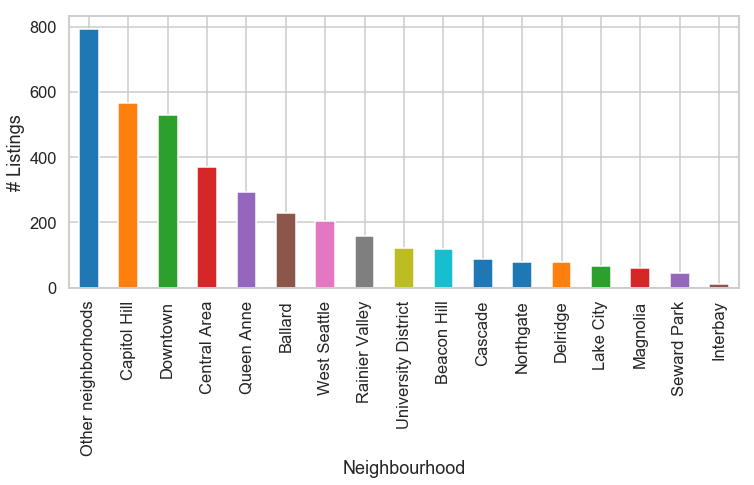

In [9]:
# number of lists by location
sns.set_context('talk')
#sns.reset_orig()
count_stats=listings.groupby(['neighbourhood_group_cleansed'], as_index=False)['id'].count()
count_stats.sort_values(by='id', ascending=False, inplace=True)
# store sorted neighborhood in 'neighborhood_sorted', this will be used in remaining analysis where neighborhood is x
neighborhood_sorted = count_stats['neighbourhood_group_cleansed'].unique()
count_stats.plot.bar(x='neighbourhood_group_cleansed', y='id', figsize=(12,5), legend=False)
plt.gca().set_xlabel("Neighbourhood")
plt.gca().set_ylabel("# Listings")

In [10]:
# guests comments by neighborhood
#reviews = reviews.merge(listings[['id', 'neighbourhood_group_cleansed']], left_on='listing_id', right_on='id',how='inner')
#count_stats=reviews.groupby(['neighbourhood_group_cleansed'], as_index=False)['reviewer_id'].count()
#count_stats.sort_values(by='reviewer_id', ascending=False, inplace=True)
#count_stats.plot.bar(x='neighbourhood_group_cleansed', y='reviewer_id', figsize=(12,5), legend=False)
#plt.gca().set_xlabel("Neighbourhood")
#plt.gca().set_ylabel("# Reviews")

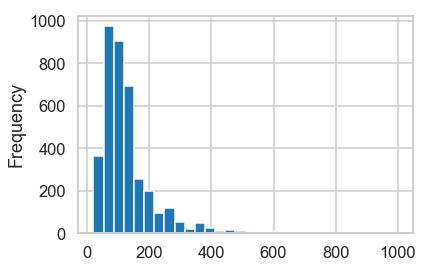

In [11]:
# histogram of listing prices
listings['price'].plot.hist(bins=30)
#plt.ylabel('price')

In [12]:
# describe listing prices
# listings['price'].describe()

In [13]:
# get average price by location. groupby and visuals. visual could be matplotlib errorbar or seaborn pointplot

In [14]:
# price by location, stats table
# price_by_area=listings.groupby(['neighbourhood_group_cleansed'],as_index=False)['price'].agg([np.mean, 'sem', 'count', 'max', 'min', 'median']).reset_index()
# price_by_area.sort_values(by='mean', ascending=False)

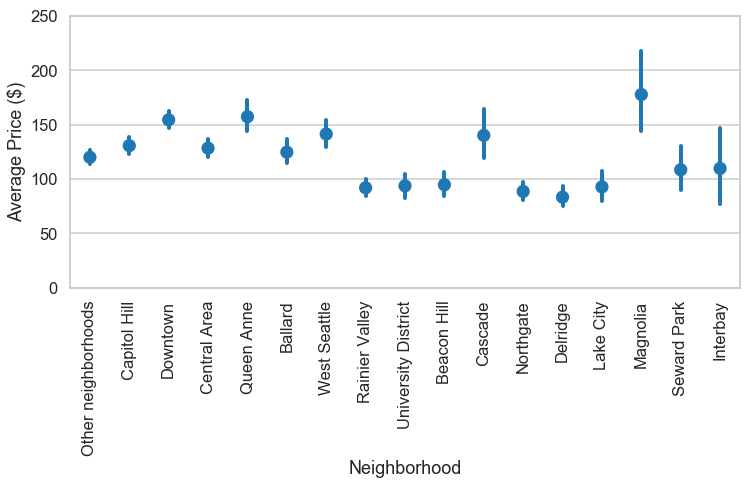

In [15]:
# matplotlib
#plt.errorbar(x=price_by_area.index.tolist(), y=price_by_area['mean'], yerr=price_by_area['sem']*2,fmt='o')
#plt.xticks(price_by_area.index.tolist())
#plt.gca().set_xticklabels(price_by_area['neighbourhood_group_cleansed'],rotation=90);
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='price', data=listings, join=False, order = neighborhood_sorted)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Average Price ($)')
ax.set_ylim(0, 250);

In [16]:
#listings.loc[listings.neighbourhood_group_cleansed=='Magnolia', 'bedrooms'].describe()
#listings.loc[listings.neighbourhood_group_cleansed=='Downtown', 'bedrooms'].describe()

In [17]:
# normalize price by bedrooms
listings.loc[listings['bedrooms']==0, 'bedrooms']=0.7
listings['price_per_bed']=listings['price']/(listings['bedrooms'])

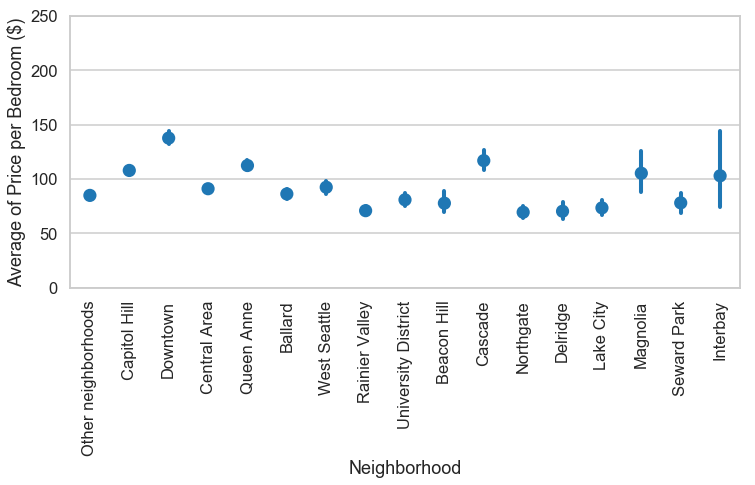

In [18]:
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='price_per_bed', data=listings, join=False, order=neighborhood_sorted)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Average of Price per Bedroom ($)')
ax.set_ylim(0, 250);

In [19]:
# review by location
# review_score_stats=listings.groupby(['neighbourhood_group_cleansed'],as_index=False)['review_scores_value'].agg([np.mean, 'sem', 'count', 'max', 'min', 'median']).reset_index()
# review_score_stats.sort_values(by='mean', ascending=False)

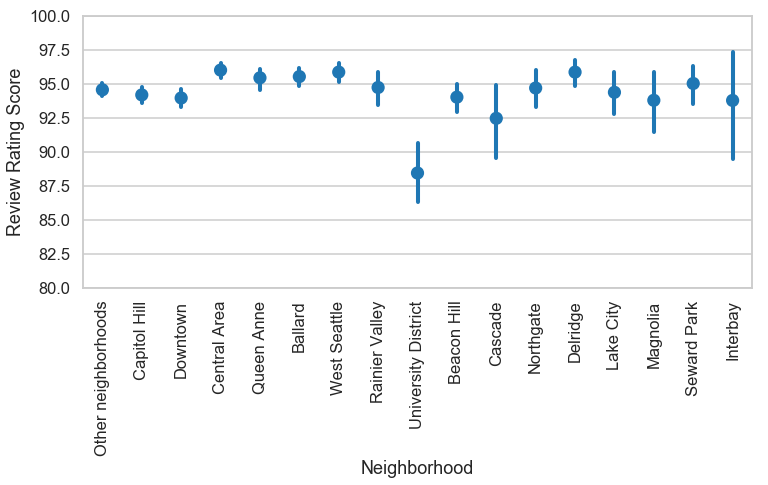

In [20]:
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='review_scores_rating', data=listings, join=False, order=neighborhood_sorted)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Review Rating Score')
ax.set_ylim(80, 100);

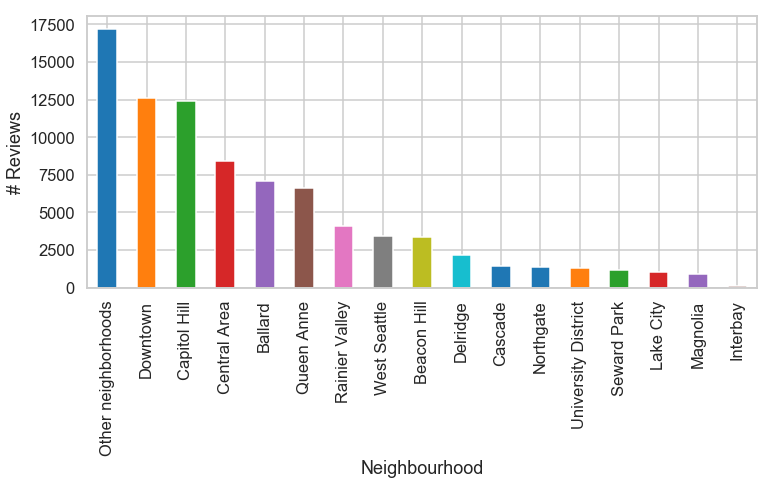

In [21]:
count_reviews=listings.groupby(['neighbourhood_group_cleansed'], as_index=False)['number_of_reviews'].sum()
count_reviews.sort_values(by='number_of_reviews', ascending=False, inplace=True)
count_reviews.plot.bar(x='neighbourhood_group_cleansed', y='number_of_reviews', figsize=(12,5), legend=False)
plt.gca().set_xlabel("Neighbourhood")
plt.gca().set_ylabel("# Reviews");

In [22]:
# percent super host by location
#listings['host_is_superhost']=listings['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
#pct_super_by_area=listings.groupby(['neighbourhood_group_cleansed'],as_index=False)['host_is_superhost'].mean()
#pct_super_by_area.sort_values(by='host_is_superhost', ascending=False)

#### Question #2, neighborhood vibe using listing descriptions?

In [23]:
# need to download nltk if not used before otherwise will pop up TK errors
#nltk.download()

In [24]:
# vibe using listing descriptions
# I'll be answering this question by looking at first 30 most frequently used words for each neighborhood
from nltk.probability import FreqDist
stopwords_to_remove = set(stopwords.words('english'))
others_to_remove=[',', '.', ')', '(', '!', ':', '&', '-', 'The', 'This', 'I', 'It', 'There', 'We', 'You', 'room', 'Seattle', 'home', "'s"]
#l_neighborhoods = listings['neighbourhood_group_cleansed'].unique()
for neigh in neighborhood_sorted:
    tokens_all = []
    for comment in listings.loc[listings['neighbourhood_group_cleansed']==neigh, 'description'].tolist():
        tokens = nltk.word_tokenize(comment)
        tokens = [x for x in tokens if x not in stopwords_to_remove]
        tokens = [x for x in tokens if x not in others_to_remove]
        tokens_all = tokens_all + tokens
    fdist = FreqDist(tokens_all).most_common(30)
    print(neigh + ': ')
    print(fdist)

Other neighborhoods: 
[('kitchen', 619), ('house', 600), ('bedroom', 582), ('bed', 547), ('neighborhood', 537), ('downtown', 478), ('private', 461), ('bathroom', 441), ('space', 437), ('bus', 432), ('apartment', 432), ('access', 423), ('restaurants', 412), ('one', 406), ('living', 393), ('full', 364), ('two', 357), ('available', 341), ('2', 338), ('floor', 332), ('Fremont', 329), ('located', 320), ('Lake', 307), ('away', 293), ('great', 287), ('area', 287), ('parking', 278), ('large', 272), ('queen', 261), ('quiet', 261)]
Capitol Hill: 
[('Hill', 653), ('Capitol', 625), ('apartment', 514), ('kitchen', 403), ('restaurants', 364), ('bedroom', 364), ('bed', 352), ('space', 339), ('house', 315), ('walk', 303), ('downtown', 299), ('one', 286), ('access', 284), ('located', 259), ('living', 251), ('neighborhood', 250), ('full', 242), ('area', 236), ('away', 236), ('bus', 229), ('private', 228), ('blocks', 227), ('bathroom', 225), ('two', 219), ('2', 203), ('great', 202), ('bars', 201), ('floo

#### Question #3, busiest times of the year to visit Seattle? By how much do price spike

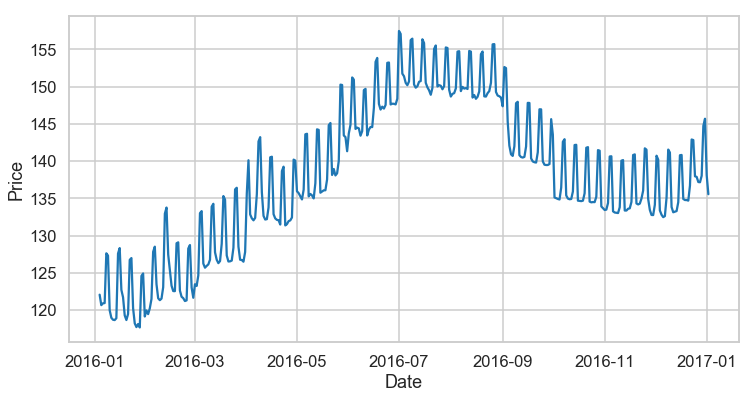

In [25]:
avgByDate=calendar.groupby(['date'], as_index=False)['price'].mean()
plt.figure(figsize=(12,6))
sns.lineplot(data=avgByDate, x='date', y='price')
plt.gca().set_xlabel("Date")
plt.gca().set_ylabel("Price");
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [26]:
# use # of reviews as proxy of demand to confirm demand by time
#reviews_less = reviews.loc[(reviews['date'].dt.year>=2010) & (reviews['date'].dt.year<=2015), :]
#reviews_less['month'] = reviews_less['date'].dt.month
#nCommentsByDate = reviews_less.groupby(['month'], as_index = False)['id'].count()
#plt.figure(figsize=(12,6))
#sns.lineplot(data=nCommentsByDate, x='month', y='id')

In [27]:
# time trends for average price for each neighborhood. merge with listings to get neighborhood information first
#calendar['week']=calendar['date'].dt.week
calendar = pd.merge(calendar, listings[['id', 'neighbourhood_group_cleansed']], left_on='listing_id', right_on='id',how='inner')

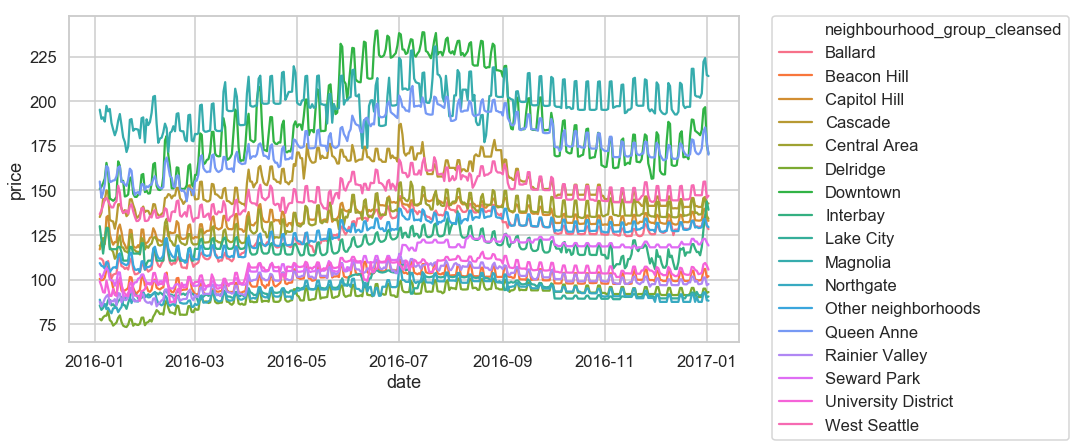

In [28]:
neighbor_avg_by_date=calendar.groupby(['neighbourhood_group_cleansed', 'date'], as_index=False)['price'].mean()
plt.figure(figsize=(12,6))
sns.lineplot(data=neighbor_avg_by_date, x='date', y='price', hue='neighbourhood_group_cleansed')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### Question #4, What do people generally say about the listings and difference by neighborhood?

In [29]:
# what did reviewers say about the listings. word count of reviews by neighborhood
reviews=reviews.merge(listings[['id', 'neighbourhood_group_cleansed']], how='inner', left_on='listing_id', right_on='id')

In [30]:
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer() 
#tokens = [lemmatizer.lemmatize(x) for x in tokenhttp://localhost:8888/notebooks/Dropbox/jobs/Projects/Udacity/seattle-airbnb-data/notebook.ipynb#s]

stopwords_to_remove = set(stopwords.words('english'))
others_to_remove=['.', ',', '(', ')', '&', ':', '!', '-', '*', 'The', 'This', 'I', 'We', 'us', 'It', 'room', 'Seattle', 'home', "'s", 
                  "n't", 'would']
# others_to_remove=[',', '.', ')', '(', '!', ':', '&', '-', 'The', 'This', 'I', 'It', 'There', 'We', 'You', 'room', 'Seattle', 'home', "'s"]
# l_neighborhoods = listings['neighbourhood_group_cleansed'].unique()

for neigh in neighborhood_sorted:
    tokens_all = []
    for comment in reviews.loc[(reviews['neighbourhood_group_cleansed']==neigh) & pd.notnull(reviews['comments']), 'comments'].tolist():
        tokens = nltk.word_tokenize(comment)
        tokens = [x for x in tokens if x not in stopwords_to_remove]
        tokens = [x for x in tokens if x not in others_to_remove]
        tokens_all = tokens_all + tokens

    fdist = FreqDist(tokens_all).most_common(30)
    print(neigh + ': ')
    print(fdist)

Other neighborhoods: 
[('stay', 10894), ('great', 10424), ('place', 8302), ('house', 5811), ('comfortable', 5451), ('clean', 5359), ('neighborhood', 4660), ('location', 4636), ('nice', 4497), ('host', 4259), ('apartment', 3700), ('time', 3648), ('recommend', 3289), ('easy', 3247), ('really', 3138), ('perfect', 3028), ('well', 3020), ('everything', 2949), ('definitely', 2878), ('space', 2768), ('wonderful', 2690), ('quiet', 2672), ('made', 2628), ('area', 2508), ('also', 2486), ('restaurants', 2438), ('experience', 2327), ('needed', 2322), ('She', 2286), ('downtown', 2270)]
Capitol Hill: 
[('great', 8524), ('stay', 7227), ('place', 6638), ('location', 5043), ('apartment', 4791), ('clean', 4003), ('host', 3284), ('comfortable', 3214), ('nice', 2863), ('neighborhood', 2783), ('time', 2593), ('Hill', 2530), ('house', 2485), ('easy', 2436), ('recommend', 2424), ('restaurants', 2366), ('really', 2264), ('everything', 2186), ('definitely', 2131), ('Capitol', 2095), ('perfect', 2072), ('well',